# PST - Phase Stretch Transform

Ported from: https://github.com/JalaliLabUCLA/Image-feature-detection-using-Phase-Stretch-Transform/    

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

from skimage import data, io, filters, color
from ipywidgets import widgets

In [2]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [3]:
from itertools import zip_longest
def imshow_pair(image_pair, titles=('', ''), figsize=(10, 5), **kwargs):
    fig, axes = plt.subplots(ncols=len(image_pair), figsize=figsize)
    for ax, img, label in zip_longest(axes.ravel(), image_pair, titles, fillvalue=''):
        ax.imshow(img, **kwargs)
        ax.set_title(label)

In [4]:
# LPF            : Gaussian low-pass filter Full Width at Half Maximum (FWHM) (min : 0, max : 1)
# Phase_strength : PST  kernel Phase Strength (min : 0, max : 1)
# Warp_strength  : PST Kernel Warp Strength (min : 0, max : 1)
# Thresh_min     : minimum Threshold  (min : -1, max : 0)
# Thresh_max     : maximum Threshold  (min : 0, max : 1)
def PST(I, LPF=0.21, Phase_strength = 0.48, Warp_strength = 12.14, Thresh_min = -1, Thresh_max = 0.0019, Morph_flag=False):
    I = color.rgb2gray(I)
    img_shape = np.shape(I)
    L = 0.5
    x = np.linspace(-L, L, img_shape[0])
    y = np.linspace(-L, L, img_shape[1])
    X, Y = np.meshgrid(x, y)
    
    theta, rho = cart2pol(X, Y)
    
    X_step = x[1] - x[0]
    fx = np.linspace(-0.5 / X_step, 0.5/X_step, len(x))
    fx_step = fx[1] - fx[0]

    Y_step = y[1] - y[0]
    fy = np.linspace(-0.5 / Y_step, 0.5 / Y_step, len(y))
    fy_step = fy[1] - fy[0]

    FX, FY = np.meshgrid(fx, fy)
    
    ftheta, frho = cart2pol(FX, FY)
    
    img_orig_f = np.fft.fft2(I)
    sigma = LPF**2 / np.log(2)
    img_orig_f *= np.fft.fftshift(np.exp(-(rho / np.sqrt(sigma))**2))
    image_orig_filtered = np.real(np.fft.ifft2(img_orig_f))
    
    PST_Kernel = (rho * Warp_strength * np.arctan(rho * Warp_strength) - 0.5 * np.log(1 + (rho * Warp_strength)**2))
    PST_Kernel /= np.max(np.max(PST_Kernel)) * Phase_strength
    
    temp = np.fft.fft2(image_orig_filtered) * np.fft.fftshift(np.exp( -1j * PST_Kernel))
    Image_orig_filtered_PST = np.fft.ifft2(temp)
    
    PHI_features = np.angle(Image_orig_filtered_PST)
    
    if Morph_flag:
        features = np.zeros_like(PHI_features)
        features[PHI_features > Thresh_max] = 1
        features[PHI_features < Thresh_min] = 1 # because output phase has both positive and negative values
        features[ I < (np.max(I) / 20) ] = 0 # ignore the features in the very dark areas of the image

        import mahotas as mh
        out = features
        out = mh.thin(out, 1)
        out = mh.bwperim(out, 4)
        out = mh.thin(out, 1)
        # Removes isolated pixels (individual 1s that are surrounded by 0s)
        # out = mh.erode(out, np.ones((30, 30))); # out = mh.dilate(out) 

        return out
    else:
        return PHI_features

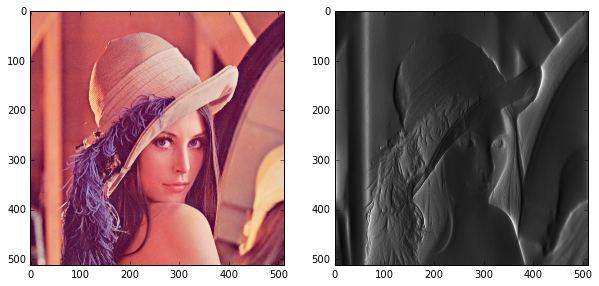

In [5]:
@widgets.interact_manual
def experiment(
        LPF: (0.0, 1.0, 0.01) = 0.21, 
        Phase_strength: (0.0, 1.0, 0.01) = 0.48, 
        Warp_strength: (0.0, 1.0, 0.01) = 12.14, 
        Morph_flag = False, 
        Thresh_min: (-1.0, 0.0, 0.01) = -1, 
        Thresh_max: (0.0, 1.0, 0.01) = 0.0019):
    
    I = data.lena()
    pst = PST(I, LPF, Phase_strength, Warp_strength, Thresh_min, Thresh_max, Morph_flag)
    if not Morph_flag :
        pst /= np.max(np.max(pst))*3
    
    imshow_pair((I, pst), cmap='gray')